# Задание 3.1 - Сверточные нейронные сети (Convolutional Neural Networks)

Это последнее задание на numpy, вы до него дожили! Остался последний марш-бросок, дальше только PyTorch.

В этом задании вы реализуете свою собственную сверточную нейронную сеть.

In [6]:
!git clone https://github.com/Hreaun/DL.git
!cp DL/assignment3/*.py .
!./DL/assignment3/download_data.sh
!rm -rf DL

fatal: destination path 'DL' already exists and is not an empty directory.


[autoreload of layers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ModuleNotFoundError: No module named 'assignment3'
]


mkdir: cannot create directory ‘data’: File exists
--2021-03-30 02:37:39--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-03-30 02:37:39--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

На этот раз мы не будем их преобразовывать в один вектор, а оставим размерности (num_samples, 32, 32, 3).

In [9]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Реализуем новые слои!

Сначала основной новый слой - сверточный (Convolutional layer). 
Для начала мы реализуем его для только одного канала, а потом для нескольких.

Сверточный слой выполняет операцию свертки (convolution) с весами для каждого канала, а потом складывает результаты. 
Возможно, поможет пересмотреть Лекцию 6 или внимательно прочитать
http://cs231n.github.io/convolutional-networks/

Один из подходов к реализации сверточного слоя основан на том, что для конкретного "пикселя" выхода применение сверточного слоя эквивалентно обычному полносвязному.  
Рассмотрим один такой "пиксель":
![image.png](attachment:image.png)

Он получает на вход   
регион входа I размера `(batch_size, filter_size, filter_size, input_channels)`,  
применяет к нему веса W `(filter_size, filter_size, input_channels, output_channels`
и выдает `(batch_size, output_channels)`. 

Если:  
- вход преобразовать в I' `(batch_size, filter_size*filter_size*input_channels)`,  
- веса в W' `(filter_size*filter_size*input_channels, output_channels)`,  
то выход "пикселе" будет эквивалентен полносвязному слою со входом I' и весами W'.

Осталось выполнить его в цикле для каждого пикселя :)

In [84]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:", X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


## А теперь имплементируем обратный проход
Возможно, это самое сложное место в курсе. Дальше будет лучше.

Раз выполнение сверточного слоя эквивалентно полносвязному слою для каждого "пикселя" выхода, то общий обратный проход эквивалентен обратному проходу каждого из таких "слоев".  
Градиенты от каждого из этих "слоев" в каждом пикселе надо сложить в соответствующие пиксели градиента по входу, а градиенты весов сложить все вместе.

In [83]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


Осталось реализовать дополнение нулями (padding).   
Достаточно дополнить входной тензор нулями по сторонам. Не забудьте учесть это при обратном проходе!

In [85]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

Gradient check passed!


## После следующего слоя вам уже будет все ни по чем - max pooling

Max Pooling - это слой, реализующий операцию максимума для каждого канала отдельно в окресности из `pool_size` "пикселей".

![image](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

И напомним что такое stride.  
Stride - это на сколько "пикселей" сдвигается окно на одном шаге.  
Вот здесь, например, stride = 2

![image.png](http://deeplearning.net/software/theano/_images/no_padding_strides.gif)

На практике, для max pooling значение stride часто равно pool size.

In [101]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)

Gradient check passed!


И на закуску - слой, преобразующий четырехмерные тензоры в двумерные.

Этот слой понадобится нам, чтобы в конце сети перейти от сверточных слоев к полносвязным.

In [104]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


# Теперь есть все кирпичики, создаем модель

In [108]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for conv1_W
Gradient check passed!
Checking gradient for conv1_B
Gradient check passed!
Checking gradient for conv2_W
Gradient check passed!
Checking gradient for conv2_B
Gradient check passed!
Checking gradient for fully_connected_W
Gradient check passed!
Checking gradient for fully_connected_B
Gradient check passed!


True

# Оптимизатор и код для тренировки 
Должен заработать с кодом из прошлого задания без изменений!

In [115]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-4, num_epochs=50)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.301368, Train accuracy: 0.125000, val accuracy: 0.062500
Loss: 2.301211, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.301055, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300899, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300743, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300587, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300432, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300276, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.300120, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299965, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299810, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299655, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299500, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299345, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299190, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 2.299035, Train acc

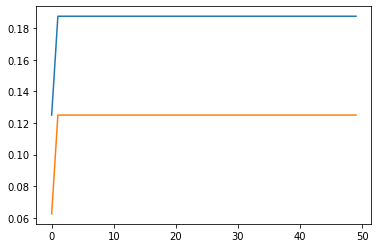

In [116]:
plt.plot(train_history)
plt.plot(val_history)

# Последнее упражнение
В качестве последнего упражнения мы доведем точность на тренировочном наборе данных до 100% на небольшом наборе данных.
Сверточные сети требуют большого количества вычислений и аккуратной эффективной реализации, поэтому настоящие модели мы будем тренировать уже на PyTorch в следующем задании.

## Итак, оверфитим маленький набор данных


In [131]:
data_size = 128

learning_rates = [1e-2, 1e-3]
learning_rate_decays = [0.999, 0.95]
conv_layer_sizes = [4, 8]
batch_sizes = [8, 16]

best_classifier = None
best_train_accuracy = 0

best_learning_rate = 0
best_decay = 0
best_conv_layer_size1 = 0
best_conv_layer_size2 = 0
best_batch_size = 0

loss_history = []
train_history = []
val_history = []

k = 1

for learning_rate in learning_rates:
    for conv_layer_size1 in conv_layer_sizes:
      for conv_layer_size2 in conv_layer_sizes:
        for decay in learning_rate_decays:
            for batch_size in batch_sizes:
              model = ConvNet(input_shape=(32,32,3), n_output_classes=10, 
                              conv1_channels=conv_layer_size1,
                              conv2_channels=conv_layer_size2)
              dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
              # TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
              # Hint: If you have hard time finding the right parameters manually, try grid search or random search!
              trainer = Trainer(model, dataset, MomentumSGD(), 
                                learning_rate=learning_rate,
                                num_epochs=50,
                                batch_size=batch_size,
                                learning_rate_decay=decay)
              loss_history_cur, train_history_cur, val_history_cur = trainer.fit()
              print("iteration", k)
              k += 1
              if (train_history_cur[-1] > best_train_accuracy):
                  loss_history = loss_history_cur
                  train_history = train_history_cur
                  val_history = val_history_cur

                  best_learning_rate = learning_rate
                  best_decay = decay
                  best_conv_layer_size1 = conv_layer_size1
                  best_conv_layer_size2 = conv_layer_size2
                  best_batch_size = batch_size
                  best_train_accuracy = train_history_cur[-1]
                  best_classifier = model

print('learning_rate={learning_rate}, decay={decay}, conv1={conv1}, conv2={conv2}, bs={bs}'
.format(learning_rate=best_learning_rate,
        decay=best_decay,
        conv1=best_conv_layer_size1,
        conv2=best_conv_layer_size2,
        bs=best_batch_size
        ))
print('best train accuracy achieved: %f' % best_train_accuracy)


Loss: 2.257040, Train accuracy: 0.179688, val accuracy: 0.203125
Loss: 2.149921, Train accuracy: 0.203125, val accuracy: 0.203125
Loss: 1.962860, Train accuracy: 0.218750, val accuracy: 0.242188
Loss: 2.104959, Train accuracy: 0.289062, val accuracy: 0.210938
Loss: 1.977477, Train accuracy: 0.273438, val accuracy: 0.226562
Loss: 1.785558, Train accuracy: 0.304688, val accuracy: 0.203125
Loss: 2.055478, Train accuracy: 0.312500, val accuracy: 0.203125
Loss: 1.931316, Train accuracy: 0.367188, val accuracy: 0.140625
Loss: 1.689836, Train accuracy: 0.351562, val accuracy: 0.210938
Loss: 1.997549, Train accuracy: 0.359375, val accuracy: 0.195312
Loss: 2.061876, Train accuracy: 0.398438, val accuracy: 0.195312
Loss: 1.688297, Train accuracy: 0.421875, val accuracy: 0.218750
Loss: 1.648139, Train accuracy: 0.390625, val accuracy: 0.203125
Loss: 1.463906, Train accuracy: 0.468750, val accuracy: 0.218750
Loss: 1.481968, Train accuracy: 0.515625, val accuracy: 0.171875
Loss: 1.993629, Train acc

In [149]:
data_size = 128

learning_rate = 1e-3
decay = 0.9999
batch_size = 8

model = ConvNet(input_shape=(32,32,3), n_output_classes=10, 
                              conv1_channels=20,
                              conv2_channels=8)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(), 
                  learning_rate=learning_rate,
                  num_epochs=200,
                  batch_size=batch_size,
                  learning_rate_decay=decay)
loss_history, train_history, val_history = trainer.fit()

Loss: 5.302884, Train accuracy: 0.195312, val accuracy: 0.109375
Loss: 3.260982, Train accuracy: 0.101562, val accuracy: 0.101562
Loss: 2.491365, Train accuracy: 0.273438, val accuracy: 0.171875
Loss: 3.123338, Train accuracy: 0.273438, val accuracy: 0.226562
Loss: 4.432654, Train accuracy: 0.265625, val accuracy: 0.109375
Loss: 4.973287, Train accuracy: 0.210938, val accuracy: 0.164062
Loss: 2.020665, Train accuracy: 0.328125, val accuracy: 0.179688
Loss: 2.328198, Train accuracy: 0.414062, val accuracy: 0.203125
Loss: 2.693755, Train accuracy: 0.421875, val accuracy: 0.179688
Loss: 2.068404, Train accuracy: 0.382812, val accuracy: 0.171875
Loss: 2.116813, Train accuracy: 0.398438, val accuracy: 0.140625
Loss: 2.395889, Train accuracy: 0.234375, val accuracy: 0.093750
Loss: 1.913830, Train accuracy: 0.507812, val accuracy: 0.125000
Loss: 1.236069, Train accuracy: 0.460938, val accuracy: 0.195312
Loss: 2.009523, Train accuracy: 0.539062, val accuracy: 0.234375
Loss: 2.701031, Train acc

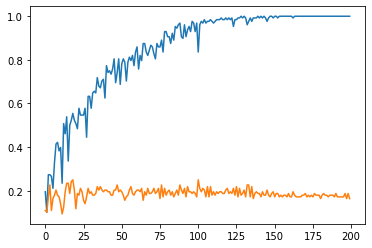

In [150]:
plt.plot(train_history)
plt.plot(val_history)

Дальнейшие упражнения - уже на PyTorch, открывайте следующий notebook!

![image.png](attachment:image.png)